In [ ]:
#Time Series Forecasting with ARIMA

In [ ]:
#ARIMA stands for Autoregressive Integrated Moving Average. It depends on below paramter
#P -> If current value is dependedent on previous values. If yes, how many values are to be considered
#    The significant lags can be found using PACF

#D -> The series has a trend associated with it. You remove the impact of trend by difference.
#    We need to share the level of different that removes the impact of trend
#    Dicky Fuller test can be used to check if the series is stationary or not

#Q -> The current value also uses past error to calculate the current value. It shows how many errors are to be considered in this scenario
#    The siginicant lags can be determined using ACF

#Once we have P, D and Q values, we can build the ARIMA model using those parameters.
#Auto_ARIMA is an automated way of finding the best parameters for ARIMA model by trying out different combinations of P, D and Q
#and selecting the best one based on AIC/BIC values.

#AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are statistical measures used to compare different models and select the best one.
#AIC = -2ln(L) + 2k
#BIC = -2ln(L) + k * ln(n)

#Where L is the likelihood of the model and k is the number of parameters and n is the number of observations (sample size)
#The likelihood of the model indicates how well the model fits the data.
#    $$\ell(\theta) = -\frac{T}{2} \ln(2\pi) - \frac{T}{2} \ln(\sigma^2) - \frac{1}{2\sigma^2} \sum_{t=1}^{T} \epsilon_t^2$$
#    $T$: Number of observations.
#    $\sigma^2$: Variance of the errors.
#    $\epsilon_t$: The residual (actual value minus predicted value).

#The ARIMA equation so formed is then validated with Ljung-Box test to check if the residual errors are white noise or not.

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('C:/Sahil Folders/Github Projects/Sahil-Assignments/Time Series Forecasting/Test Data/date_count.csv')

In [ ]:
data

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


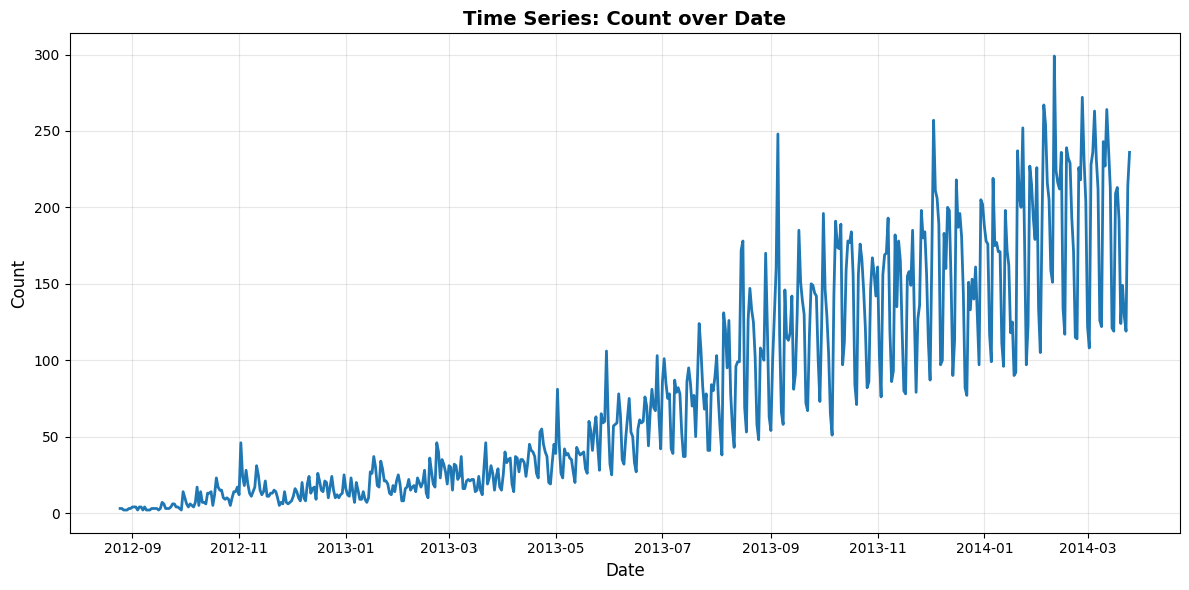

In [ ]:
# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create line plot
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['count'], linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Time Series: Count over Date', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Set Date as index for time series analysis
data_ts = data.set_index('Date')

# Display first few rows
print("Time Series Data:")
print(data_ts.head())
print(f"\nData shape: {data_ts.shape}")
print(f"Date range: {data_ts.index.min()} to {data_ts.index.max()}")


Time Series Data:
            count
Date             
2012-08-25      3
2012-08-26      3
2012-08-27      2
2012-08-28      2
2012-08-29      2

Data shape: (578, 1)
Date range: 2012-08-25 00:00:00 to 2014-03-25 00:00:00


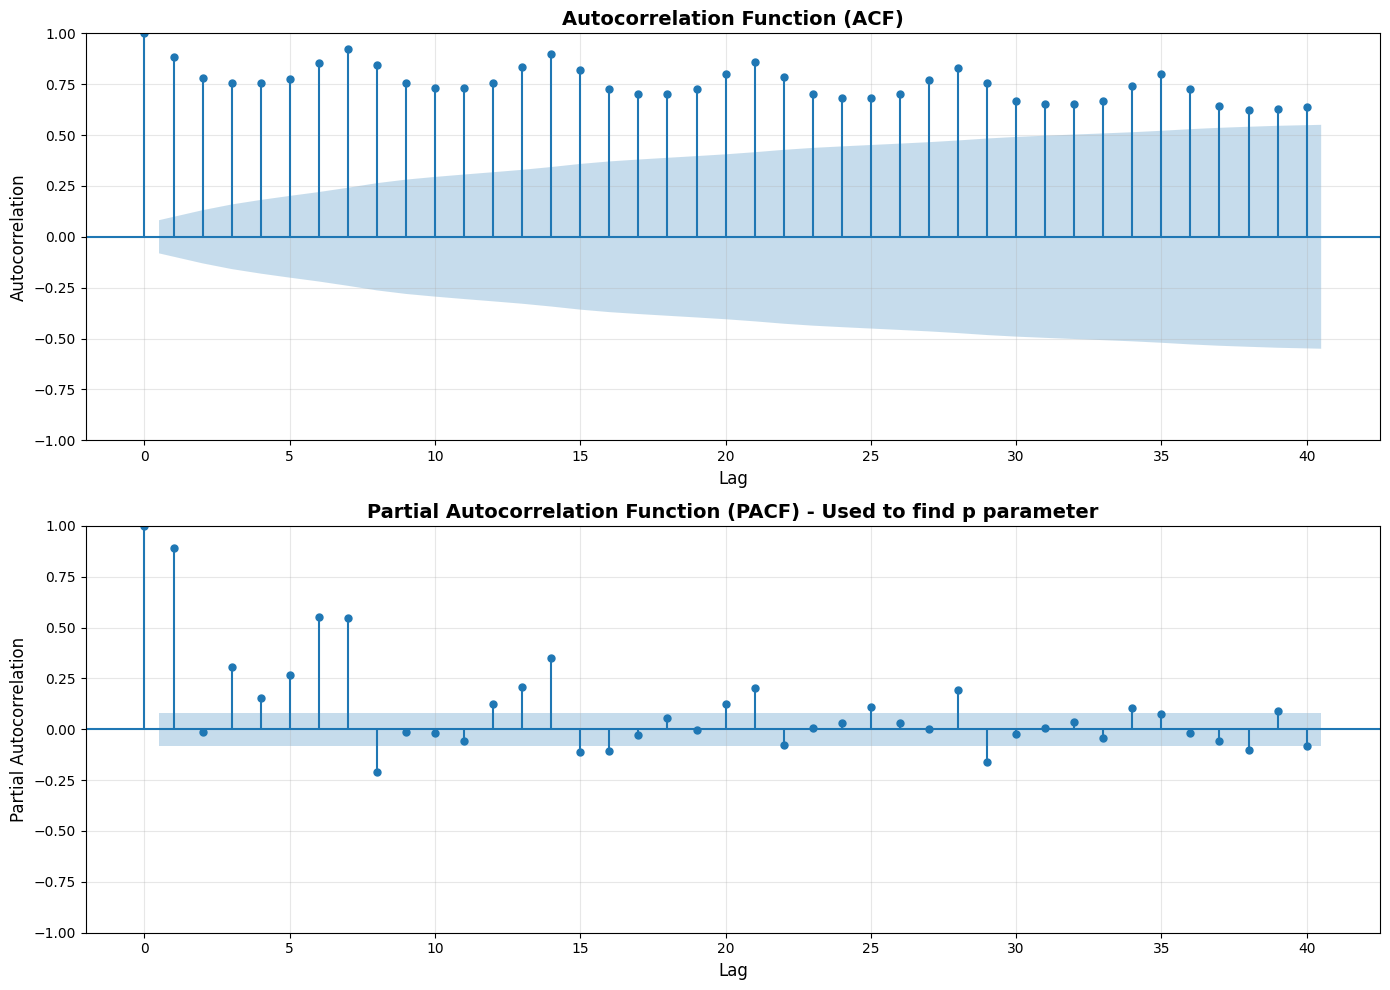


ACF and PACF Analysis for finding p parameter

PACF values (first 10 lags):
  Lag 0: 1.0000
  Lag 1: 0.8933
  Lag 2: -0.0128
  Lag 3: 0.3048
  Lag 4: 0.1522
  Lag 5: 0.2678
  Lag 6: 0.5501
  Lag 7: 0.5485
  Lag 8: -0.2107
  Lag 9: -0.0120


In [ ]:
# Calculate ACF and PACF values
acf_values = acf(data_ts['count'], nlags=40, fft=True)
pacf_values = pacf(data_ts['count'], nlags=40, method='ols')

# Create subplots for ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot ACF (Autocorrelation Function)
plot_acf(data_ts['count'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot PACF (Partial Autocorrelation Function) - Used to find p value
plot_pacf(data_ts['count'], lags=40, ax=axes[1], alpha=0.05, method='ols')
axes[1].set_title('Partial Autocorrelation Function (PACF) - Used to find p parameter',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display ACF and PACF values
print("\n" + "="*60)
print("ACF and PACF Analysis for finding p parameter")
print("="*60)
print("\nPACF values (first 10 lags):")
for i in range(min(10, len(pacf_values))):
    print(f"  Lag {i}: {pacf_values[i]:.4f}")


In [ ]:
# Find significant lags in PACF (where PACF cuts off)
# Typically, we look for lags where PACF is significant (outside confidence interval)
# The confidence interval is approximately ±1.96/sqrt(n) for 95% confidence

n = len(data_ts)
confidence_interval = 1.96 / np.sqrt(n)

print("\n" + "="*60)
print("Finding p value from PACF")
print("="*60)
print(f"95% Confidence Interval: ±{confidence_interval:.4f}")
print(f"\nSignificant PACF lags (outside confidence interval):")

significant_lags = []
for i in range(1, min(20, len(pacf_values))):  # Check first 20 lags
    if abs(pacf_values[i]) > confidence_interval:
        significant_lags.append(i)
        print(f"  Lag {i}: {pacf_values[i]:.4f} (significant)")

if significant_lags:
    # The p value is typically the lag where PACF cuts off
    # We look for the first lag after which PACF becomes insignificant
    # Or we can use the last significant lag
    suggested_p = significant_lags[0] if significant_lags else 1
    print(f"\nSuggested p value (AR order): {suggested_p}")
    print(f"Note: This is based on the first significant lag in PACF.")
    print(f"      You may want to try p = {suggested_p} or nearby values (e.g., {suggested_p-1 if suggested_p > 1 else 1} to {suggested_p+1})")
else:
    print("\nNo significant lags found in first 20 lags.")
    print("Suggested p value: 1 (start with p=1)")



Finding p value from PACF
95% Confidence Interval: ±0.0815

Significant PACF lags (outside confidence interval):
  Lag 1: 0.8933 (significant)
  Lag 3: 0.3048 (significant)
  Lag 4: 0.1522 (significant)
  Lag 5: 0.2678 (significant)
  Lag 6: 0.5501 (significant)
  Lag 7: 0.5485 (significant)
  Lag 8: -0.2107 (significant)
  Lag 12: 0.1231 (significant)
  Lag 13: 0.2098 (significant)
  Lag 14: 0.3503 (significant)
  Lag 15: -0.1129 (significant)
  Lag 16: -0.1092 (significant)

Suggested p value (AR order): 1
Note: This is based on the first significant lag in PACF.
      You may want to try p = 1 or nearby values (e.g., 1 to 2)


In [ ]:
# ============================================================================
# Finding d parameter (Differencing order) - Check for Stationarity
# ============================================================================

def adf_test(timeseries, title="Time Series"):
    """
    Perform Augmented Dickey-Fuller test to check stationarity
    """
    print(f"\n{'='*60}")
    print(f"ADF Test for {title}")
    print(f"{'='*60}")

    result = adfuller(timeseries, autolag='AIC')

    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.6f}")

    if result[1] <= 0.05:
        print(f"\n✓ Series is STATIONARY (p-value <= 0.05)")
        print(f"  → No differencing needed (d = 0)")
        return True
    else:
        print(f"\n✗ Series is NON-STATIONARY (p-value > 0.05)")
        print(f"  → Differencing may be needed")
        return False

# Test original series for stationarity
is_stationary_original = adf_test(data_ts['count'], "Original Series")

# If not stationary, test first difference
d_value = 0
if not is_stationary_original:
    data_diff1 = data_ts['count'].diff().dropna()
    is_stationary_diff1 = adf_test(data_diff1, "First Differenced Series")

    if is_stationary_diff1:
        d_value = 1
        print(f"\n{'='*60}")
        print(f"CONCLUSION: d = 1 (First differencing makes series stationary)")
        print(f"{'='*60}")
    else:
        # Test second difference
        data_diff2 = data_diff1.diff().dropna()
        is_stationary_diff2 = adf_test(data_diff2, "Second Differenced Series")

        if is_stationary_diff2:
            d_value = 2
            print(f"\n{'='*60}")
            print(f"CONCLUSION: d = 2 (Second differencing makes series stationary)")
            print(f"{'='*60}")
        else:
            print(f"\n{'='*60}")
            print(f"Note: Series may require d > 2, but typically d=1 or d=2 is sufficient")
            print(f"Suggested: Try d = 1 or d = 2")
            print(f"{'='*60}")
            d_value = 1  # Default suggestion
else:
    print(f"\n{'='*60}")
    print(f"CONCLUSION: d = 0 (Original series is already stationary)")
    print(f"{'='*60}")

print(f"\nSuggested d value (Differencing order): {d_value}")



ADF Test for Original Series
ADF Statistic: -0.056611
p-value: 0.953592
Critical Values:
   1%: -3.442124
   5%: -2.866734
   10%: -2.569536

✗ Series is NON-STATIONARY (p-value > 0.05)
  → Differencing may be needed

ADF Test for First Differenced Series
ADF Statistic: -9.171646
p-value: 0.000000
Critical Values:
   1%: -3.442145
   5%: -2.866743
   10%: -2.569541

✓ Series is STATIONARY (p-value <= 0.05)
  → No differencing needed (d = 0)

CONCLUSION: d = 1 (First differencing makes series stationary)

Suggested d value (Differencing order): 1


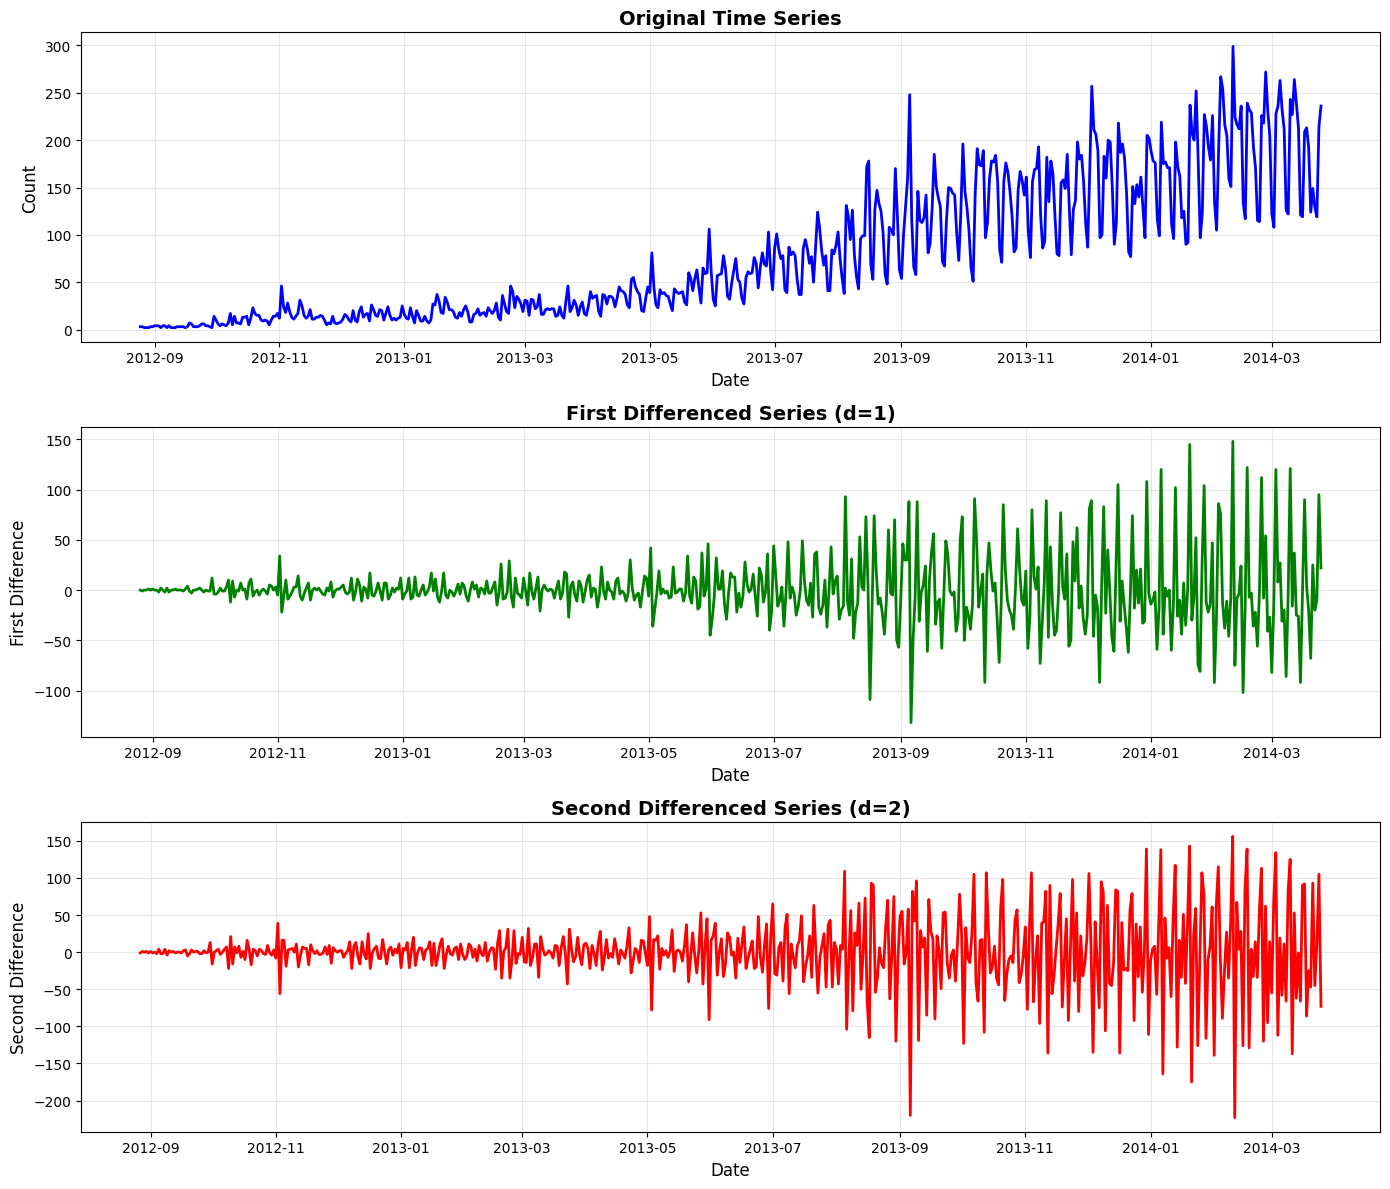

In [ ]:
# Visualize original and differenced series
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Original series
axes[0].plot(data_ts.index, data_ts['count'], linewidth=2, color='blue')
axes[0].set_title('Original Time Series', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(True, alpha=0.3)

# First difference
data_diff1 = data_ts['count'].diff().dropna()
axes[1].plot(data_diff1.index, data_diff1, linewidth=2, color='green')
axes[1].set_title('First Differenced Series (d=1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('First Difference', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Second difference
data_diff2 = data_diff1.diff().dropna()
axes[2].plot(data_diff2.index, data_diff2, linewidth=2, color='red')
axes[2].set_title('Second Differenced Series (d=2)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Second Difference', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


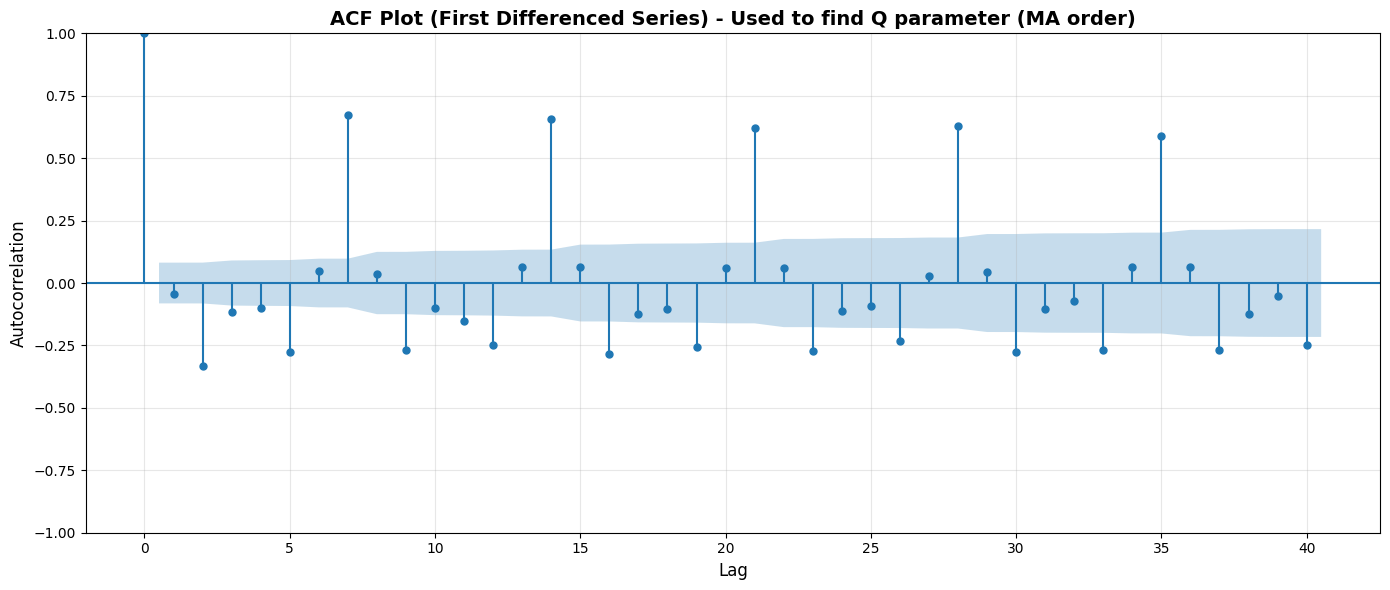


Finding Q value from ACF (First Differenced Series)
95% Confidence Interval: ±0.0816

Significant ACF lags (outside confidence interval):
  Lag 2: -0.3330 (significant)
  Lag 3: -0.1180 (significant)
  Lag 4: -0.1007 (significant)
  Lag 5: -0.2781 (significant)
  Lag 7: 0.6736 (significant)
  Lag 9: -0.2699 (significant)
  Lag 10: -0.0989 (significant)
  Lag 11: -0.1534 (significant)
  Lag 12: -0.2497 (significant)
  Lag 14: 0.6589 (significant)
  Lag 16: -0.2855 (significant)
  Lag 17: -0.1222 (significant)
  Lag 18: -0.1060 (significant)
  Lag 19: -0.2548 (significant)

Suggested Q value (MA order): 2
Note: This is based on the first significant lag in ACF.
      You may want to try Q = 2 or nearby values (e.g., 1 to 3)

SUMMARY: Q parameter (MA order) = 2


In [ ]:
# ============================================================================
# Finding Q parameter (MA order) using ACF plot
# ============================================================================

# Use the differenced series if d > 0, otherwise use original
if d_value == 0:
    series_for_acf = data_ts['count']
    series_name = "Original Series"
elif d_value == 1:
    series_for_acf = data_ts['count'].diff().dropna()
    series_name = "First Differenced Series"
else:
    series_for_acf = data_ts['count'].diff().diff().dropna()
    series_name = "Second Differenced Series"

# Calculate ACF values for the appropriate series
acf_values_q = acf(series_for_acf, nlags=40, fft=True)

# Create ACF plot for finding Q
plt.figure(figsize=(14, 6))
plot_acf(series_for_acf, lags=40, ax=plt.gca(), alpha=0.05)
plt.title(f'ACF Plot ({series_name}) - Used to find Q parameter (MA order)',
          fontsize=14, fontweight='bold')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find significant lags in ACF
n = len(series_for_acf)
confidence_interval_q = 1.96 / np.sqrt(n)

print("\n" + "="*60)
print(f"Finding Q value from ACF ({series_name})")
print("="*60)
print(f"95% Confidence Interval: ±{confidence_interval_q:.4f}")
print(f"\nSignificant ACF lags (outside confidence interval):")

significant_lags_acf = []
for i in range(1, min(20, len(acf_values_q))):  # Check first 20 lags
    if abs(acf_values_q[i]) > confidence_interval_q:
        significant_lags_acf.append(i)
        print(f"  Lag {i}: {acf_values_q[i]:.4f} (significant)")

if significant_lags_acf:
    # The Q value is typically the lag where ACF cuts off
    # We look for the first lag where ACF becomes insignificant
    suggested_q = significant_lags_acf[0] if significant_lags_acf else 0
    print(f"\nSuggested Q value (MA order): {suggested_q}")
    print(f"Note: This is based on the first significant lag in ACF.")
    print(f"      You may want to try Q = {suggested_q} or nearby values (e.g., {max(0, suggested_q-1)} to {suggested_q+1})")
else:
    print("\nNo significant lags found in first 20 lags.")
    print("Suggested Q value: 0 (start with Q=0)")
    suggested_q = 0

print(f"\n{'='*60}")
print(f"SUMMARY: Q parameter (MA order) = {suggested_q}")
print(f"{'='*60}")


In [ ]:
# ============================================================================
# Final Summary: All ARIMA Parameters (p, d, q)
# ============================================================================

print("\n" + "="*70)
print("ARIMA PARAMETERS SUMMARY")
print("="*70)

# Get the suggested p from previous analysis
# Recalculate to ensure we have the value
n = len(data_ts)
confidence_interval = 1.96 / np.sqrt(n)
pacf_values_summary = pacf(data_ts['count'], nlags=40, method='ols')

significant_lags_p = []
for i in range(1, min(20, len(pacf_values_summary))):
    if abs(pacf_values_summary[i]) > confidence_interval:
        significant_lags_p.append(i)

suggested_p = significant_lags_p[0] if significant_lags_p else 1

print(f"\n✓ P (AR order) = {suggested_p}")
print(f"  → Found using PACF plot")
print(f"  → Significant PACF lags: {significant_lags_p[:5] if len(significant_lags_p) > 0 else 'None'}")

print(f"\n✓ D (Differencing order) = {d_value}")
if d_value == 0:
    print(f"  → Original series is stationary (no differencing needed)")
elif d_value == 1:
    print(f"  → First differencing makes series stationary")
else:
    print(f"  → Second differencing makes series stationary")

print(f"\n✓ Q (MA order) = {suggested_q}")
print(f"  → Found using ACF plot on {'original' if d_value == 0 else 'differenced'} series")
print(f"  → Significant ACF lags: {significant_lags_acf[:5] if len(significant_lags_acf) > 0 else 'None'}")

print(f"\n{'='*70}")
print(f"RECOMMENDED ARIMA MODEL: ARIMA({suggested_p}, {d_value}, {suggested_q})")
print(f"{'='*70}")
print(f"\nNote: These are initial suggestions. You may want to:")
print(f"  - Try nearby values (e.g., p±1, q±1)")
print(f"  - Use AIC/BIC to compare different models")
print(f"  - Consider seasonal ARIMA if there's seasonality")
print(f"{'='*70}\n")



ARIMA PARAMETERS SUMMARY

✓ P (AR order) = 1
  → Found using PACF plot
  → Significant PACF lags: [1, 3, 4, 5, 6]

✓ D (Differencing order) = 1
  → First differencing makes series stationary

✓ Q (MA order) = 2
  → Found using ACF plot on differenced series
  → Significant ACF lags: [2, 3, 4, 5, 7]

RECOMMENDED ARIMA MODEL: ARIMA(1, 1, 2)

Note: These are initial suggestions. You may want to:
  - Try nearby values (e.g., p±1, q±1)
  - Use AIC/BIC to compare different models
  - Consider seasonal ARIMA if there's seasonality



In [ ]:
!pip install pmdarima


In [ ]:
!pip install scalecast

In [ ]:
from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.auxmodels import auto_arima

In [ ]:
# Use the parameters found from our analysis
# Based on ACF/PACF analysis: p=1, d=1, q=2
# Set ideal start and end parameter values for auto_arima

f = Forecaster(y=data['count'], current_dates=data['Date'])
f.set_estimator('arima')  # set arima

# Ideal parameter ranges based on our analysis:
# Start values: Use our findings (p=1, d=1, q=2) as starting point
# End values: Reasonable maximums (typically p,q up to 5-6, d up to 2, seasonal up to 2)

auto_arima(
    f,
    start_p=suggested_p,      # Start with our PACF analysis result (p=1)
    start_d=d_value,           # Start with our ADF test result (d=1)
    start_q=suggested_q,        # Start with our ACF analysis result (q=2)
    max_p=5,                    # Maximum AR order (reasonable upper limit)
    max_d=2,                    # Maximum differencing (rarely need more than 2)
    max_q=5,                    # Maximum MA order (reasonable upper limit)
    m=12,                       # Seasonal period (monthly data)
    seasonal=True,              # Enable seasonal ARIMA
    start_P=0,                 # Start seasonal AR order
    start_D=0,                 # Start seasonal differencing
    start_Q=0,                 # Start seasonal MA order
    max_P=2,                    # Maximum seasonal AR order
    max_D=1,                    # Maximum seasonal differencing
    max_Q=2,                    # Maximum seasonal MA order
    trace=True,                 # Show search progress
    error_action='ignore',      # Ignore errors during search
    suppress_warnings=True,     # Suppress warnings
    stepwise=True,              # Use stepwise search (faster)
    information_criterion="aic", # Use AIC for model selection
    alpha=0.05,                 # Significance level
    scoring='mse',              # Scoring metric
    call_me='arima_optimized',  # Name for the model
)


Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5455.862, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5689.003, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5651.460, Time=1.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5541.777, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5687.087, Time=0.02 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=5447.078, Time=1.83 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=5413.256, Time=5.44 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=5423.495, Time=6.76 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=5412.579, Time=3.14 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=5445.748, Time=1.09 sec
 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=5421.964, Time=4.73 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=5434.005, Time=2.31 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5464.646, Time=2.76 sec
 ARIMA(0,1,3)(2,0,0)[12]

ForecastError: Before calling a model, please make sure you have generated future dates by calling generate_future_dates(), set_last_future_date(), or ingest_Xvars_df(use_future_dates=True).

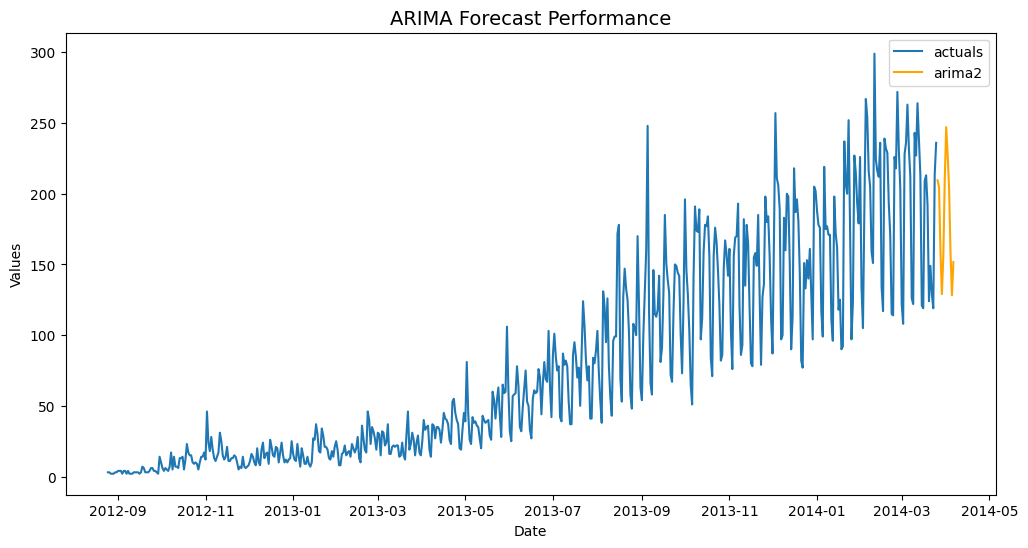

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  578
Model:             ARIMA(2, 1, 3)x(2, 0, [], 12)   Log Likelihood               -2591.903
Date:                           Sat, 27 Dec 2025   AIC                           5199.806
Time:                                   00:10:31   BIC                           5234.669
Sample:                                        0   HQIC                          5213.401
                                           - 578                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2447      0.002    655.639      0.000       1.241       1.248
ar.L2         -0.9987      0.002   -475.337      0.000      -1.003      -0.995
ma.L1         -2.0465      0.025    -80.896      0.000      -2.096      -1.997
ma.L2          1.9500      0.035     56.452      0.000       1.882       2.018
ma.L3         -0.7628      0.025    -30.838      0.000      -0.811      -0.714
ar.S.L12      -0.2597      0.031     -8.412      0.000      -0.320      -0.199
ar.S.L24       0.1529      0.032      4.749      0.000       0.090       0.216
sigma2       472.6919     17.779     26.587      0.000     437.846     507.538
===================================================================================
Ljung-Box (L1) (Q):                   1.89   Jarque-Bera (JB):               544.40
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):              21.68   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
f.generate_future_dates(12) # 12-month forecast horizon
f.set_test_length(.2) # 20% test set
f.set_estimator('arima') # set arima

# Forecast
f.manual_forecast(order=(2,1,3),seasonal_order=(2,0,0,12),call_me='arima2')


# View forecast results
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

# See summary stats
f.regr.summary()